# Virtual bidding in NYISO's markets

Deadline:
Nov 27 2023

In this lab, we will implement a simple virtual trading strategy in New York
ISO's electricity markets. The goal is to maximize profits. We shall train our
model on price data from one year, and implement the strategy on the data from
the next year. How much can you earn with a certain daily budget? Say \$250K?

We will present a trading strategy. You are welcome to try other strategies and compare the gains over multiple runs.

Let's start with customary imports.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Load the day-ahead and real-time prices from 11 zones in New York.

The day-ahead prices are defined every hour. The real-time market runs every 5 minutes. For each zone, an average of
these prices over an hour is published.

Store the list of zones in the variable 'listOfZones'. Also, store the number of options
as the number of zones times the 24 hours available for trading. Finally create another
list containing the option names (zone + hour).

In [59]:
listOfZones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL', 'MHK VL',
               'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']

nOptions = len(listOfZones) * 24
optionNames = [zone + "_Hour_" + str(t) for zone in listOfZones for t in range(24)]


## Parse the files with DA and RT prices along with DA load forecast.

Define a function that parses three files containing DA and RT prices, along with DA load predictions from a year from all different zones in the list defined before. This function will be used for to both load the data for training the classifiers and testing them. This function has 3 outputs: they are DA prices, difference between DA and RT prices, and finally DA load predictions. The outputs are pandas data frames whose columns are the options, and rows are the days in the year.

In [60]:
def loadNYISOData(year):

    # Open the relevant files for DA prices, RT prices, DA load.

    dfPriceDA = pd.read_csv("DAM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfPriceRT = pd.read_csv("RTM_NYISO_Zonal_LBMP_" + str(year) + ".csv")
    dfLoadDA = pd.read_csv("DAM_NYISO_LoadForecast_" + str(year) + ".csv")

    # Collect the DA and RT prices from each zone from each hour and create a pandas list.
    # The data should have prices and loads from all days of a year, where each day
    # contributes 24 rows, corresponding to each hour.

    priceDA = pd.DataFrame({zone: (dfPriceDA.loc[dfPriceDA['Zone Name'] == zone,
                                                 'DAM Zonal LBMP']).values
                             for zone in listOfZones})
    priceRT = pd.DataFrame({zone: (dfPriceRT.loc[dfPriceRT['Zone Name'] == zone,
                                                 'TWI Zonal LBMP']).values
                             for zone in listOfZones})
    loadDA = pd.DataFrame({zone: (dfLoadDA.loc[dfLoadDA['Zone Name'] == zone,
                                               'DAM Forecast Load']).values
                            for zone in listOfZones})

    numberOfDays = int(len(priceDA.index)/24)

    # Compute the price differences between DA and RT prices for all options on
    # all days of the year. Store it as a pandas data frame where the 24 rows for
    # each day is flattened into one row. This operation essentially allows us to
    # independently think of each zone in each hour as a separate option. Also,
    # reshape the prices for the DA market in the same manner.

    priceDART = pd.DataFrame([priceRT.sub(priceDA).loc[day * 24:
                                                              (day + 1) * 24 - 1,
                              listOfZones].values.flatten()
                              for day in range(numberOfDays)],
                             columns=optionNames)

    priceDA = pd.DataFrame([priceDA.loc[day * 24: (day + 1) * 24 - 1,
                            listOfZones].values.flatten()
                            for day in range(numberOfDays)],
                           columns=optionNames)

    return priceDA, priceDART, loadDA


## Create a function that creates the inputs for training a classifier

Create a function that takes the price and load data and creates two arrays
'X' and 'Y'. Essentially, the rows of 'X' contains all information relevant to
 predicting the sign of the price difference on the various options on the next day.
 It takes as an input, three pandas frames corresponding to the DA prices, price
 differences, and the DA load predictions, and produces three outputs:
 the arrays 'X', 'Y', and the range of days from the year that were used to
 create the data 'X' and 'Y'. This function will be used to both train and
 test classifiers.

In [61]:
def createClassifierIO(priceDA, priceDART, loadDA):

    # Define how many past days of prices to use for classification.

    pastPrices = range(1, 3)

    # Define how many past days of load predictions to use for classification.

    pastLoad = range(1, 3)

    # Define a date range within the year to create the arrays 'X' and 'Y' in a way
    # that past price and load data for the first day is within the date range in the
    # pandas frames passed as inputs.

    rangeOfDays = range(3, len(priceDA.index))

    # 'X' will contain three sets of variables:
    #   1. the DA prices from past days in the list 'pastDays',
    #   2. the differences between DA and RT prices from the same past days,
    #   3. the load predictions from past days in the list 'pastLoad'

    X = [np.concatenate((
        priceDA.loc[[(day - h) for h in pastPrices]].values.flatten(),
        priceDART.loc[[(day - h) for h in pastPrices]].values.flatten(),
        loadDA.loc[[(day - h) for h in pastLoad]].values.flatten()
    )) for day in rangeOfDays]

    # Scale the array 'X' to make its data zero mean and unit variance.
    X = StandardScaler().fit_transform(X)

    # 'Y' will contain zeros and ones, where a one indicates that the price in DA is
    # higher than in RT for a particular option. Recall that an option corresponds to
    # a zone at a particular hour of the day.

    Y = np.array([(priceDART.loc[day].values > 0).astype(int)
                  for day in rangeOfDays])

    # Return the arrays 'X' and 'Y', and finally the range of days from the year that
    # will be utilized for training or testing the classifier.
    return X, Y, rangeOfDays

## Design the training module.
 The training module utilizes a year's worth of data to determine the following for
 each option, i.e., for each zone for each hour of the day:
   1. Classifiers that predict the sign of the difference between DA and RT prices.
   2. Statistics of the mean of the price difference.
   3. A quantile of the day-ahead prices that we will use as our bid for each option.
 You will either train the classifiers here or load them from the folder './Classifiers'.
 Storing the classifiers from time to time allows you to only vary the bidding strategy
 and observe the annual reward rather than having to train the classifiers every time.
 
### Define and train the classifiers or load pre-trained classifiers.

In [62]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    classifiers = [MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=200)
                   for _ in range(nOptions)]

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option CAPITL_Hour_11


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option CAPITL_Hour_14


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL_Hour_20
Classifier trained for option CAPITL_Hour_21
Classifier trained for option CAPITL_Hour_22
Classifier trained for option CAPITL_Hour_23
Classifier trained for option CENTRL_Hour_0
Classifier trained for option CENTRL_Hour_1
Classifier trained for option CENTRL_Hour_2
Classifier trained for option CENTRL_Hour_3
Classifier trained for option CENTRL_Hour_4
Classifier trained for option CENTRL_Hour_5
Classifier trained for option CENTRL_Hour_6
Classifier trained for option CENTRL_Hour_7
Classifier trained for option CENTRL_Hour_8
Classifier trained for option CENTRL_Hour_9
Classifier trained for option CENTRL_Hour_10
Classifier trained for option CENTRL_Hour_11
Classifier trained for option CENTRL_Hour_12
Classifier trained for option CENTRL_Hour_13
Classifier trained for option CENTRL_Hour_14
Classifier trained for option CENTRL_Hour_15
Classifier trained f

/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option CENTRL_Hour_17
Classifier trained for option CENTRL_Hour_18
Classifier trained for option CENTRL_Hour_19


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option CENTRL_Hour_20
Classifier trained for option CENTRL_Hour_21


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option CENTRL_Hour_22
Classifier trained for option CENTRL_Hour_23


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option DUNWOD_Hour_0
Classifier trained for option DUNWOD_Hour_1
Classifier trained for option DUNWOD_Hour_2
Classifier trained for option DUNWOD_Hour_3
Classifier trained for option DUNWOD_Hour_4
Classifier trained for option DUNWOD_Hour_5
Classifier trained for option DUNWOD_Hour_6
Classifier trained for option DUNWOD_Hour_7
Classifier trained for option DUNWOD_Hour_8
Classifier trained for option DUNWOD_Hour_9
Classifier trained for option DUNWOD_Hour_10


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option DUNWOD_Hour_11
Classifier trained for option DUNWOD_Hour_12
Classifier trained for option DUNWOD_Hour_13
Classifier trained for option DUNWOD_Hour_14
Classifier trained for option DUNWOD_Hour_15
Classifier trained for option DUNWOD_Hour_16
Classifier trained for option DUNWOD_Hour_17
Classifier trained for option DUNWOD_Hour_18
Classifier trained for option DUNWOD_Hour_19
Classifier trained for option DUNWOD_Hour_20
Classifier trained for option DUNWOD_Hour_21
Classifier trained for option DUNWOD_Hour_22
Classifier trained for option DUNWOD_Hour_23
Classifier trained for option GENESE_Hour_0
Classifier trained for option GENESE_Hour_1
Classifier trained for option GENESE_Hour_2
Classifier trained for option GENESE_Hour_3


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option GENESE_Hour_4
Classifier trained for option GENESE_Hour_5
Classifier trained for option GENESE_Hour_6


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option GENESE_Hour_7
Classifier trained for option GENESE_Hour_8
Classifier trained for option GENESE_Hour_9
Classifier trained for option GENESE_Hour_10
Classifier trained for option GENESE_Hour_11
Classifier trained for option GENESE_Hour_12


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option GENESE_Hour_13
Classifier trained for option GENESE_Hour_14
Classifier trained for option GENESE_Hour_15
Classifier trained for option GENESE_Hour_16
Classifier trained for option GENESE_Hour_17
Classifier trained for option GENESE_Hour_18
Classifier trained for option GENESE_Hour_19


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option GENESE_Hour_20
Classifier trained for option GENESE_Hour_21
Classifier trained for option GENESE_Hour_22
Classifier trained for option GENESE_Hour_23
Classifier trained for option HUD VL_Hour_0
Classifier trained for option HUD VL_Hour_1


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option HUD VL_Hour_2
Classifier trained for option HUD VL_Hour_3
Classifier trained for option HUD VL_Hour_4
Classifier trained for option HUD VL_Hour_5
Classifier trained for option HUD VL_Hour_6
Classifier trained for option HUD VL_Hour_7
Classifier trained for option HUD VL_Hour_8
Classifier trained for option HUD VL_Hour_9
Classifier trained for option HUD VL_Hour_10
Classifier trained for option HUD VL_Hour_11
Classifier trained for option HUD VL_Hour_12
Classifier trained for option HUD VL_Hour_13
Classifier trained for option HUD VL_Hour_14
Classifier trained for option HUD VL_Hour_15


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option HUD VL_Hour_16
Classifier trained for option HUD VL_Hour_17
Classifier trained for option HUD VL_Hour_18
Classifier trained for option HUD VL_Hour_19
Classifier trained for option HUD VL_Hour_20
Classifier trained for option HUD VL_Hour_21
Classifier trained for option HUD VL_Hour_22
Classifier trained for option HUD VL_Hour_23
Classifier trained for option LONGIL_Hour_0


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option LONGIL_Hour_1
Classifier trained for option LONGIL_Hour_2
Classifier trained for option LONGIL_Hour_3
Classifier trained for option LONGIL_Hour_4
Classifier trained for option LONGIL_Hour_5


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option LONGIL_Hour_6
Classifier trained for option LONGIL_Hour_7


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option LONGIL_Hour_8


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option LONGIL_Hour_9
Classifier trained for option LONGIL_Hour_10


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option LONGIL_Hour_11
Classifier trained for option LONGIL_Hour_12
Classifier trained for option LONGIL_Hour_13
Classifier trained for option LONGIL_Hour_14
Classifier trained for option LONGIL_Hour_15
Classifier trained for option LONGIL_Hour_16
Classifier trained for option LONGIL_Hour_17
Classifier trained for option LONGIL_Hour_18


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option LONGIL_Hour_19


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option LONGIL_Hour_20
Classifier trained for option LONGIL_Hour_21
Classifier trained for option LONGIL_Hour_22
Classifier trained for option LONGIL_Hour_23
Classifier trained for option MHK VL_Hour_0
Classifier trained for option MHK VL_Hour_1
Classifier trained for option MHK VL_Hour_2


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MHK VL_Hour_3
Classifier trained for option MHK VL_Hour_4
Classifier trained for option MHK VL_Hour_5


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MHK VL_Hour_6
Classifier trained for option MHK VL_Hour_7
Classifier trained for option MHK VL_Hour_8
Classifier trained for option MHK VL_Hour_9
Classifier trained for option MHK VL_Hour_10
Classifier trained for option MHK VL_Hour_11
Classifier trained for option MHK VL_Hour_12
Classifier trained for option MHK VL_Hour_13
Classifier trained for option MHK VL_Hour_14


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MHK VL_Hour_15


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MHK VL_Hour_16
Classifier trained for option MHK VL_Hour_17


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MHK VL_Hour_18


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MHK VL_Hour_19
Classifier trained for option MHK VL_Hour_20
Classifier trained for option MHK VL_Hour_21


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MHK VL_Hour_22
Classifier trained for option MHK VL_Hour_23


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MILLWD_Hour_0


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MILLWD_Hour_1
Classifier trained for option MILLWD_Hour_2
Classifier trained for option MILLWD_Hour_3
Classifier trained for option MILLWD_Hour_4


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MILLWD_Hour_5
Classifier trained for option MILLWD_Hour_6


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MILLWD_Hour_7


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MILLWD_Hour_8


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MILLWD_Hour_9
Classifier trained for option MILLWD_Hour_10
Classifier trained for option MILLWD_Hour_11


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option MILLWD_Hour_12
Classifier trained for option MILLWD_Hour_13
Classifier trained for option MILLWD_Hour_14
Classifier trained for option MILLWD_Hour_15
Classifier trained for option MILLWD_Hour_16
Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option N.Y.C._Hour_2


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option N.Y.C._Hour_5


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8
Classifier trained for option N.Y.C._Hour_9


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option N.Y.C._Hour_12
Classifier trained for option N.Y.C._Hour_13
Classifier trained for option N.Y.C._Hour_14


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option N.Y.C._Hour_15
Classifier trained for option N.Y.C._Hour_16
Classifier trained for option N.Y.C._Hour_17
Classifier trained for option N.Y.C._Hour_18


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option N.Y.C._Hour_19
Classifier trained for option N.Y.C._Hour_20
Classifier trained for option N.Y.C._Hour_21
Classifier trained for option N.Y.C._Hour_22


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option N.Y.C._Hour_23
Classifier trained for option NORTH_Hour_0
Classifier trained for option NORTH_Hour_1
Classifier trained for option NORTH_Hour_2
Classifier trained for option NORTH_Hour_3
Classifier trained for option NORTH_Hour_4
Classifier trained for option NORTH_Hour_5
Classifier trained for option NORTH_Hour_6


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option NORTH_Hour_7
Classifier trained for option NORTH_Hour_8
Classifier trained for option NORTH_Hour_9
Classifier trained for option NORTH_Hour_10


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option NORTH_Hour_11
Classifier trained for option NORTH_Hour_12
Classifier trained for option NORTH_Hour_13


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option NORTH_Hour_14
Classifier trained for option NORTH_Hour_15


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option NORTH_Hour_16
Classifier trained for option NORTH_Hour_17
Classifier trained for option NORTH_Hour_18
Classifier trained for option NORTH_Hour_19


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option NORTH_Hour_20
Classifier trained for option NORTH_Hour_21


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option NORTH_Hour_22
Classifier trained for option NORTH_Hour_23


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option WEST_Hour_0
Classifier trained for option WEST_Hour_1
Classifier trained for option WEST_Hour_2
Classifier trained for option WEST_Hour_3
Classifier trained for option WEST_Hour_4
Classifier trained for option WEST_Hour_5
Classifier trained for option WEST_Hour_6


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option WEST_Hour_7
Classifier trained for option WEST_Hour_8
Classifier trained for option WEST_Hour_9
Classifier trained for option WEST_Hour_10
Classifier trained for option WEST_Hour_11
Classifier trained for option WEST_Hour_12


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option WEST_Hour_13


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option WEST_Hour_14


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option WEST_Hour_15
Classifier trained for option WEST_Hour_16
Classifier trained for option WEST_Hour_17


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option WEST_Hour_18
Classifier trained for option WEST_Hour_19
Classifier trained for option WEST_Hour_20


/Users/abhaynarayanan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier trained for option WEST_Hour_21
Classifier trained for option WEST_Hour_22
Classifier trained for option WEST_Hour_23

Overall training accuracy = 99.97 percent.


### Test the classifier's accuracy on test data.

In [63]:
# First, load the test data from NYISO for the year 2016. Again, utilize our function
# named 'loadNYISOData'.

print("Starting the testing module...\n")
testPriceDA, testPriceDART, testLoadDA = loadNYISOData(2016)

# Create the data for the classifier using the function 'createClassifierIO'.
testX, testY, rangeOfDays = createClassifierIO(testPriceDA, testPriceDART, testLoadDA)

# The next step is not useful for implementing the trading strategy, but quickly check how accurate
# your trained classifiers are for the test data. Training accuracy is not always indicative of
# test accuracy.

testingAccuracy = [classifiers[ii].score(testX, testY[:, ii]) for ii in range(nOptions)]
print("Test Accuracy Stats: Min = %.2f%%, Avg = %.2f%%, Max = %.2f%%" %
      (100 * np.min(testingAccuracy),
       100 * np.mean(testingAccuracy),
       100 * np.max(testingAccuracy)))

# Utilize the classifiers to predict the sign of DA - RT prices for each day in 'rangeOfDays' for
# the test data. Store the result in a pandas data frame with columns as the option names and the
# day in year as index.
predictedY = pd.DataFrame(np.column_stack([classifiers[ii].predict(testX) for ii in range(nOptions)]),
                          columns=optionNames, index=rangeOfDays)

Starting the testing module...

Test Accuracy Stats: Min = 48.76%, Avg = 59.02%, Max = 72.45%


## Design and implement the trading strategy. 

We define a fairly simple trading strategy. Define a total budget that you are willing to spend in the DA market. Recall that we only invest in
options where we buy at the DA market and sell at the RT market. When your bid for one unit of an option
clears in the DA market, you have to pay the DA price for that option. There are two possibilities:
  1. Your bid clears: Therefore, your offer price was higher than the DA price.
  2. Your bid does not clear: Then, the DA price was higher than your bid.
In both these cases, the maximum you have to pay is your bid. Therefore, we will enforce that your bids
across all options in a day does not exceed your total budget.
Keep track of how rewards grow (or fall) through the year
as you utilize your strategy. Also, keep track of how much rewards you get from each option. We shall
visualize these results after implementing the trading strategy over the NYISO data for 2016.

Choose the bid prices as a suitable quantile of the historical DA prices. The higher the quantile, the
better your chances are that your bid will be cleared. However, a higher quantile also indicates that
you are budgeting more money for each option, and hence, you will buy fewer options.

In [64]:
dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Day 3: Reward (in $) = -85,483
Day 4: Reward (in $) = 1,602,876
Day 5: Reward (in $) = 25,905
Day 6: Reward (in $) = -22,602
Day 7: Reward (in $) = -11,922
Day 8: Reward (in $) = -44,626
Day 9: Reward (in $) = -33,499
Day 10: Reward (in $) = -107,442
Day 11: Reward (in $) = -39,422
Day 12: Reward (in $) = -55,313
Day 13: Reward (in $) = -11,347
Day 14: Reward (in $) = -25,041
Day 15: Reward (in $) = -4,045
Day 16: Reward (in $) = 11,560
Day 17: Reward (in $) = -77,198
Day 18: Reward (in $) = -21,254
Day 19: Reward (in $) = 23,888
Day 20: Reward (in $) = -3,920
Day 21: Reward (in $) = 61,202
Day 22: Reward (in $) = 88,618
Day 23: Reward (in $) = 29,860
Day 24: Reward (in $) = -87,661
Day 25: Reward (in $) = -90,763
Day 26: Reward (in $) = -41,905
Day 27: Reward (in $) = -7,618
Day 28: Reward (in $) = -18,392
Day 29: Reward (in $) = -28,021
Day 30: Reward (in $) = -55,328
Day 31: Reward (in $) = -33,599
Day 32: Reward (in $) = -7,379
Day 33: Reward (in $) = -243,015
Day 34: Reward (in $)

Day 260: Reward (in $) = -26,351
Day 261: Reward (in $) = 31,169
Day 262: Reward (in $) = 5,955
Day 263: Reward (in $) = -67,035
Day 264: Reward (in $) = -62,275
Day 265: Reward (in $) = -4,052
Day 266: Reward (in $) = -69,812
Day 267: Reward (in $) = -8,456
Day 268: Reward (in $) = -24,324
Day 269: Reward (in $) = -67,141
Day 270: Reward (in $) = -71,360
Day 271: Reward (in $) = -4,151
Day 272: Reward (in $) = -18,332
Day 273: Reward (in $) = -32,095
Day 274: Reward (in $) = 12,174
Day 275: Reward (in $) = 28,301
Day 276: Reward (in $) = 6,888
Day 277: Reward (in $) = 56,467
Day 278: Reward (in $) = 170,563
Day 279: Reward (in $) = -73,693
Day 280: Reward (in $) = 13,042
Day 281: Reward (in $) = -12,972
Day 282: Reward (in $) = -1,830
Day 283: Reward (in $) = -2,244
Day 284: Reward (in $) = 15,540
Day 285: Reward (in $) = -60,539
Day 286: Reward (in $) = -57,110
Day 287: Reward (in $) = -46,581
Day 288: Reward (in $) = 11,889
Day 289: Reward (in $) = 17,494
Day 290: Reward (in $) = 9,

### Task1:  Visualize the rewards (25 points)

We would like to plot the cumulative reward over the year 2016. By cumulative reward on a particular date, we mean the total reward from the start of the year till that date.

Also, plot a heat map of the returns from each option. 

#### Fill in the missing lines below.

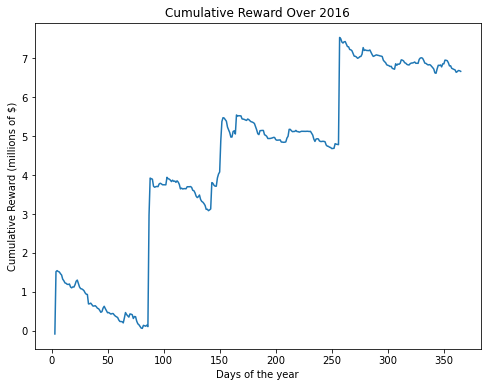

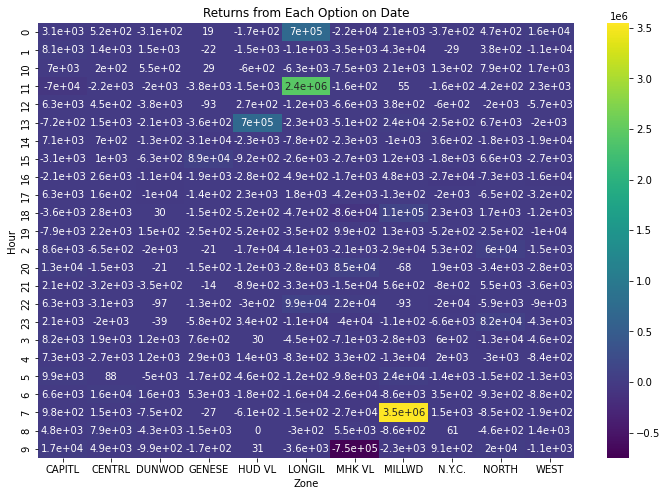

In [72]:
# Plot the cumulative reward over the year 2016. Also, plot a heat map of the returns from
# each option.


plt.figure(figsize=(8, 6))
plt.plot(rangeOfDays, list(cumulativeReward.values()))
plt.xlabel('Days of the year')
plt.ylabel('Cumulative Reward (millions of $)')
plt.title('Cumulative Reward Over 2016')

plt.show()


dftemp = pd.DataFrame(list(optionReturn.items()),columns=['Option', 'Return'])
opttemp = pd.DataFrame(list(optionReturn.items()),columns=['Option', 'Return'])['Option'].str.split('_Hour_', expand=True)

dftemp['Hour'] = opttemp[1]
dftemp['Zone'] = opttemp[0]

htmap = dftemp.pivot(index='Hour', columns='Zone', values='Return')

plt.figure(figsize=(12, 8))
sns.heatmap(htmap, cmap='viridis', annot=True)
plt.title('Returns from Each Option on Date')
plt.xlabel('Zone')
plt.ylabel('Hour')
plt.show()

### Task 2: Choosing a classifier (30 points)

We used a multilayer perceptron classifier. Your task is to try out SVM and logistic regression classifiers, and explore which one leads to more profits. Use the relevant functions from 'sklearn'.

#### (comments here, add a new code cell below)

Logistic Regression had higher profits over the year.  

N.B: To toggle between SVM and Log-Reg, comment and uncomment the relevant lines where classifiers is stated.

In [73]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    #classifiers = [SVC(kernel='rbf') for _ in range(nOptions)]  #svm
    
    
    classifiers = [LogisticRegression(max_iter=1000) for _ in range(nOptions)] #logreg

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")
    
    
# ------------------------------------------------------------------------------------------------------

dailyBudget = 250000
quantileOffer =0.8

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL

Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4
Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8
Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained for option N.Y.C._Hour_13
Classifier trained for option N.Y.C._Hour_14
Classifier trained f

Day 151: Reward (in $) = 784,084
Day 152: Reward (in $) = 502,899
Day 153: Reward (in $) = 94,985
Day 154: Reward (in $) = -7,692
Day 155: Reward (in $) = -42,212
Day 156: Reward (in $) = -38,982
Day 157: Reward (in $) = -152,244
Day 158: Reward (in $) = -72,315
Day 159: Reward (in $) = -69,595
Day 160: Reward (in $) = -114,369
Day 161: Reward (in $) = 2,424
Day 162: Reward (in $) = 144,165
Day 163: Reward (in $) = 16,102
Day 164: Reward (in $) = -82,915
Day 165: Reward (in $) = 470,711
Day 166: Reward (in $) = -27,676
Day 167: Reward (in $) = 10,384
Day 168: Reward (in $) = -2,184
Day 169: Reward (in $) = -1,722
Day 170: Reward (in $) = -78,015
Day 171: Reward (in $) = -4,025
Day 172: Reward (in $) = -8,572
Day 173: Reward (in $) = -14,851
Day 174: Reward (in $) = -10,537
Day 175: Reward (in $) = 35,711
Day 176: Reward (in $) = -15,271
Day 177: Reward (in $) = -29,629
Day 178: Reward (in $) = -24,235
Day 179: Reward (in $) = -7,735
Day 180: Reward (in $) = -13,708
Day 181: Reward (in 

### Task 3: Quantile (25 points)

For the best classifier, try different quantile choices from the following list: 0.70, 0.75, 0.80, 0.85, 0.90, 0.95. Rank them in terms of profits (low to high). 

How do you expect the quantile to affect the portfolio? 

#### (comments here, add a new code cell below)

Please note that I did not add new code below because I simply tested the quantiles in the code of Task 2. 

Considering the given quantile choices are sufficiently high, it is clear that the higher the quantile goes, the lower the profit obtained. This is because you only need a value that is sufficient to clear the day ahead price so that your bid is cleared. Having values much higher just results in a lower profit.

Ranking: 0.90, 0.85, 0.80, 0.75, 0.70 (low to high)

### Task 4: Daily budget (25 points)

We used a daily budget of 250,000. Try different budgets, let's say, 100,000, 150,000, 200,000, and 300,000. Rank them in terms of profits (low to high). Fix the quantile to the one that led to maximum profits in the previous task. 

#### (comments here, add a new code cell below)

The code below tests varying budgets from the choices given. Having observed the final profit value for all these budgets, the ranking in terms of profits is as follows: 

100,000, 150,000, 200,000, 300,000 (low to high). 

That is to say, as the budget is increased, the profit also increases.

Note: The quantile is fixed to 0.7, which yielded the highest profit in Task 3.

In [74]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    #classifiers = [SVC(kernel='rbf') for _ in range(nOptions)]  # svm
    

    classifiers = [LogisticRegression(max_iter=1000) for _ in range(nOptions)] # logreg

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")
    
    
# ------------------------------------------------------------------------------------------------------

dailyBudget = 250000
quantileOffer = 0.7

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL

Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4
Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8
Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained for option N.Y.C._Hour_13
Classifier trained for option N.Y.C._Hour_14
Classifier trained f

Day 151: Reward (in $) = 955,934
Day 152: Reward (in $) = 560,779
Day 153: Reward (in $) = 116,284
Day 154: Reward (in $) = -7,391
Day 155: Reward (in $) = -47,754
Day 156: Reward (in $) = -43,736
Day 157: Reward (in $) = -55,579
Day 158: Reward (in $) = -90,594
Day 159: Reward (in $) = -77,851
Day 160: Reward (in $) = -21,326
Day 161: Reward (in $) = 3,312
Day 162: Reward (in $) = 176,827
Day 163: Reward (in $) = 16,678
Day 164: Reward (in $) = -92,748
Day 165: Reward (in $) = 163,651
Day 166: Reward (in $) = 5,598
Day 167: Reward (in $) = 13,182
Day 168: Reward (in $) = 1,561
Day 169: Reward (in $) = 10,433
Day 170: Reward (in $) = -88,882
Day 171: Reward (in $) = -2,423
Day 172: Reward (in $) = -4,434
Day 173: Reward (in $) = -18,218
Day 174: Reward (in $) = -11,306
Day 175: Reward (in $) = 44,436
Day 176: Reward (in $) = -17,028
Day 177: Reward (in $) = -8,683
Day 178: Reward (in $) = -4,758
Day 179: Reward (in $) = -8,888
Day 180: Reward (in $) = -17,889
Day 181: Reward (in $) = -

### Task 5: Beat the algorithm! (40 points) 

Make changes to increase the profits further! Try implementing a different trading strategy. Explain what did for improvement and how much profits you made. Do not exceed the 250,000 budget!

#### (comments here, add a new code cell below)

Considering that such a situation would probably be more suitable to a linear SVM, I changed it to reflect that. This along with a slight reduction in the quantile value increased the obtained profit significantly. The new profit found in this task is $5,015,462. 

In [88]:
classifiers = []

# We have two options here. Use previous training experience, or learn anew.
useSavedClassifiers = False

if not useSavedClassifiers:

    print("Starting training module...\n")
    trainPriceDA, trainPriceDART, trainLoadDA = loadNYISOData(2015)

    numberOfDays =  int(len(trainPriceDA.index))
    print("Loaded hourly prices from 2015 for %d days." % numberOfDays)

    # We will implement a trading strategy, where we bid a particular quantile of the past
    # DA prices for an option. If you do not know what a quantile means, refer to the Wikipedia
    # article on it. Essentially, a 95% quantile of the DA prices equals that value for which
    # 95% of the DA prices are below it. Store all quantiles starting from 50% in steps of
    # 5% in a dictionary. Store them in a pickle file.

    quantilesToStore = [0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    offerPrices = trainPriceDA.quantile(q=quantilesToStore).transpose().to_dict()
    pickle.dump(offerPrices, open("./Training/OfferPrices", 'wb'))

    # Calculate the average price spread for each option over the entire year. This will guide
    # us in choosing our portfolio. Store it as a dictionary. Our bid will choose those
    # options that our classifier indicates that they will be profitable and historically they
    # have higher average price differences, indicating that they have higher rate of return.
    # Store them using pickle.

    averagePriceSpread = trainPriceDART.mean(axis=0).transpose().to_dict()
    pickle.dump(averagePriceSpread, open("./Training/AveragePriceSpread", 'wb'))

    # Create the training dataset using the function 'createClassifierIO' on the prices and
    # loads, and store them in 'trainX', and 'trainY'.

    trainX, trainY, _ = createClassifierIO(trainPriceDA, trainPriceDART, trainLoadDA)

    # Define a collection of classifiers, one for each option. You can try different options, such
    # as that based on an SVM, logistic regression, multilayer perceptron based, etc. We will
    # measure training accuracy to indicate how well the classifier works on the training dataset.
    # However, good training accuracy does not always indicate good test performance.
    # Avoid over-fitting.


    #classifiers = [SVC(kernel='rbf') for _ in range(nOptions)]  # svm
    

    classifiers = [SVC(kernel='linear') for _ in range(nOptions)]  # linear svm  

    trainingAccuracy = 0

    for ii in range(nOptions):
        classifiers[ii].fit(trainX, trainY[:, ii])
        print("Classifier trained for option " + optionNames[ii])
        trainingAccuracy += classifiers[ii].score(trainX, trainY[:, ii])

        # Store the classifier.
        pickle.dump(classifiers[ii], open("./Training/Classifier_" + optionNames[ii], 'wb'))

    print("\nOverall training accuracy = %1.2f percent." % (100 * trainingAccuracy/nOptions))

    del numberOfDays, trainPriceDA, trainLoadDA, trainPriceDART, trainX, trainY
else:

    # Load the classifiers, the offer prices at various quantiles, and the average price spreads.

    print("Loading previously trained variables...\n")
    classifiers = [pickle.load(open("./Training/Classifier_" + optionNames[ii], 'rb'))
                   for ii in range(nOptions)]
    offerPrices = pickle.load(open("./Training/OfferPrices", 'rb'))
    averagePriceSpread = pickle.load(open("./Training/AveragePriceSpread", 'rb'))

    print("All training variables were loaded successfully...\n")
    
    
# ------------------------------------------------------------------------------------------------------

dailyBudget = 250000
quantileOffer = 0.65

# Keep track of your rewards in each day, a cumulative reward over the year, and a total reward over the
# year. Also, keep track of the total reward from each option. Store them as dictionaries that are
# indexed by day of the year.
reward = {}
cumulativeReward = {}
totalReward = 0
optionReturn = dict((option, 0) for option in optionNames)

# Implement the trading strategy on each day!

for day in rangeOfDays:

    reward[day] = 0

    # Find the options that your classifier says that should be profitable. Store the profitable option
    # names in chosenOptions.
    chosenOptionNumbers = np.ravel(list(np.nonzero(predictedY.loc[day].values)))
    if np.size(chosenOptionNumbers) == 0:
        continue
    chosenOptions = [optionNames[i] for i in chosenOptionNumbers]

    # Design the portfolio based on average price spreads. Our strategy is that as long as you have not
    # exceeded your daily budget, pick an option from the list of 'chosenOptions' probabilistically, where
    # the probability of choosing it is proportional to exponential(historical rewards of that option). That
    # is, a historically profitable option is chosen more often than one that is not. Keep sampling and
    # decreasing your budget with each bid.

    # Start with an empty portfolio.

    portfolio = dict((option, 0) for option in chosenOptions)

    # Calculate the probabilities of choosing each option among the list 'chosenOptions'. Recall that
    # 'chosenOptions' contains the options that your classifier indicates as being profitable.
    priceSpreads = [1.0 * averagePriceSpread[option] for option in chosenOptions]
    probabilityOptions = [np.exp(p) for p in priceSpreads]
    probabilityOptions /= np.sum(probabilityOptions)

    # Start with your daily budget.
    budget = dailyBudget

    # Sampling among the profitable options and bid based on them.
    while budget > np.median([offerPrices[quantileOffer][option] for option in chosenOptions]):

        optionToBuy = choice(chosenOptions, p=probabilityOptions)

        if budget >= offerPrices[quantileOffer][optionToBuy]:
            portfolio[optionToBuy] += 1
            budget -= offerPrices[quantileOffer][optionToBuy]

    # Compute the reward from the day. Go through each of the options you have decided to buy.
    # If the DA price is lower than the bid price, then your bid is cleared. For each option you
    # have bought, you get a reward equal to the DA - RT price.

    for option in chosenOptions:
        if testPriceDA.at[day, option] < offerPrices[quantileOffer][option]:
            rewardOptionDay = testPriceDART.at[day, option] * portfolio[option]
            optionReturn[option] += rewardOptionDay
            reward[day] += rewardOptionDay

    totalReward += reward[day]

    # Calculate the cumulative reward in millions of dollars.
    cumulativeReward[day] = totalReward/1000000

    print("Day " + str(day) + ": Reward (in $) = " + "{0:,.0f}".format(reward[day]))

print("Total money earned over the year (in $) = " + "{0:,.0f}".format(totalReward))

Starting training module...

Loaded hourly prices from 2015 for 365 days.
Classifier trained for option CAPITL_Hour_0
Classifier trained for option CAPITL_Hour_1
Classifier trained for option CAPITL_Hour_2
Classifier trained for option CAPITL_Hour_3
Classifier trained for option CAPITL_Hour_4
Classifier trained for option CAPITL_Hour_5
Classifier trained for option CAPITL_Hour_6
Classifier trained for option CAPITL_Hour_7
Classifier trained for option CAPITL_Hour_8
Classifier trained for option CAPITL_Hour_9
Classifier trained for option CAPITL_Hour_10
Classifier trained for option CAPITL_Hour_11
Classifier trained for option CAPITL_Hour_12
Classifier trained for option CAPITL_Hour_13
Classifier trained for option CAPITL_Hour_14
Classifier trained for option CAPITL_Hour_15
Classifier trained for option CAPITL_Hour_16
Classifier trained for option CAPITL_Hour_17
Classifier trained for option CAPITL_Hour_18
Classifier trained for option CAPITL_Hour_19
Classifier trained for option CAPITL

Classifier trained for option MILLWD_Hour_17
Classifier trained for option MILLWD_Hour_18
Classifier trained for option MILLWD_Hour_19
Classifier trained for option MILLWD_Hour_20
Classifier trained for option MILLWD_Hour_21
Classifier trained for option MILLWD_Hour_22
Classifier trained for option MILLWD_Hour_23
Classifier trained for option N.Y.C._Hour_0
Classifier trained for option N.Y.C._Hour_1
Classifier trained for option N.Y.C._Hour_2
Classifier trained for option N.Y.C._Hour_3
Classifier trained for option N.Y.C._Hour_4
Classifier trained for option N.Y.C._Hour_5
Classifier trained for option N.Y.C._Hour_6
Classifier trained for option N.Y.C._Hour_7
Classifier trained for option N.Y.C._Hour_8
Classifier trained for option N.Y.C._Hour_9
Classifier trained for option N.Y.C._Hour_10
Classifier trained for option N.Y.C._Hour_11
Classifier trained for option N.Y.C._Hour_12
Classifier trained for option N.Y.C._Hour_13
Classifier trained for option N.Y.C._Hour_14
Classifier trained f

Day 151: Reward (in $) = 1,011,132
Day 152: Reward (in $) = 602,073
Day 153: Reward (in $) = 124,944
Day 154: Reward (in $) = -9,802
Day 155: Reward (in $) = -48,536
Day 156: Reward (in $) = -46,772
Day 157: Reward (in $) = -58,145
Day 158: Reward (in $) = -97,048
Day 159: Reward (in $) = -80,329
Day 160: Reward (in $) = -21,819
Day 161: Reward (in $) = 2,146
Day 162: Reward (in $) = 199,097
Day 163: Reward (in $) = 17,333
Day 164: Reward (in $) = -95,896
Day 165: Reward (in $) = 171,194
Day 166: Reward (in $) = 5,692
Day 167: Reward (in $) = 13,808
Day 168: Reward (in $) = 2,207
Day 169: Reward (in $) = 11,277
Day 170: Reward (in $) = -19,490
Day 171: Reward (in $) = -2,512
Day 172: Reward (in $) = -4,253
Day 173: Reward (in $) = -18,997
Day 174: Reward (in $) = -12,142
Day 175: Reward (in $) = 45,335
Day 176: Reward (in $) = -18,949
Day 177: Reward (in $) = -5,046
Day 178: Reward (in $) = -1,392
Day 179: Reward (in $) = -5,052
Day 180: Reward (in $) = -15,924
Day 181: Reward (in $) =